In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.model_selection import train_test_split



#SVMs
from sklearn.svm import SVC

from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score

# SVM model, for 5 different tickers, 4 different year periods.

In [2]:
#5 different tickers: Microsoft, BP, Disney, Lockheed Martin, and bitcoin.
Tickers = ["MSFT","BP","DIS","LMT","BTC-USD"]
for tick in Tickers:
    stock5 = yf.download([tick],period = "5y")
    stock10 = yf.download([tick],period = "10y")
    stock15 = yf.download([tick],period = "15y")
    stock20 = yf.download([tick],period = "20y")
    
    years = [stock5,stock10,stock15,stock20]
    yearsused = 5
    print(tick)
    for stock in years:
        #print(stock.head())
        Open = stock["Open"]
        CHANGE = np.array([])

        for i in range(0,len(Open)-1):    
            if Open[i]<Open[i+1]:
                CHANGE = np.append(CHANGE, 1)
            else:
                CHANGE = np.append(CHANGE, 0)    
        CHANGE = np.append(CHANGE, "NaN")
        stock["Change"] = CHANGE
        stock = stock[:-1]
        
        features = ["Open","Low","High","Close","Volume","Adj Close"]

        ratio = round(0.8*stock.shape[0])
        X = stock[features]
        Y = stock["Change"]

        X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=ratio)
        #print(X_train.shape, y_train.shape)
        model=SVC(kernel="linear",C=100,random_state = 42069)
        svmfit = model.fit(X_train,y_train)

        y_preds = svmfit.predict(X_test)
        print('The accuracy of the model is: {:.2f}'.format(accuracy_score(y_test, y_preds)*100),"%")
    #     print('The recall score for the dataset using SVM is',(recall_score(y_test,y_preds,pos_label="1.0")*100),'%')
    #     print('The precision percent value for the dataset using SVM is',(precision_score(y_test,y_preds,pos_label="1.0")*100),'%')
        print('The f1 value for the model is: {:.2f}'.format(f1_score(y_test,y_preds,pos_label="1.0")*100),'%')

        cm_svm = metrics.confusion_matrix(y_preds,y_test)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm_svm,annot=True,fmt="d",linewidths=.5,square=True,cmap="summer")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        all_sample_title=(tick,str(yearsused),"Stock confusion matrix")
        plt.title(all_sample_title,size=15)
        plt.show()
        yearsused = yearsused + 5

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MSFT


## Now with indicators

In [ ]:
#Moving Average function (MA)

def MA(dataset, timeframe_MA):

    Moving_Average = np.zeros(len(dataset))
    Moving_Average[:timeframe_MA-1] = "NaN"
    
    for i in range(timeframe_MA-1, len(dataset)):
        Moving_Average[i] = np.mean(dataset[i-timeframe_MA+1:i+1])
        
    return Moving_Average

#Exponential Moving Average function (EMA)

def EMA(dataset, MA, timeframe_EMA):

    Exponential_Moving_Average = np.zeros(len(dataset))
    Exponential_Moving_Average[:timeframe_EMA-1] = "NaN"
    Exponential_Moving_Average[timeframe_EMA-1] = MA[timeframe_EMA-1]
    
    multiplier = 2/(timeframe_EMA+1)
    
    for i in range(timeframe_EMA, len(dataset)):
        Exponential_Moving_Average[i] = (dataset[i] * multiplier) + (Exponential_Moving_Average[i-1] * (1-multiplier))
        
    return Exponential_Moving_Average

#Relative Strength Index function (RSI)

def RSI(dataset, timeframe_RSI):
    
    RSI = np.zeros(len(dataset))
    RSI[:timeframe_RSI] = "NaN"
    
    #for i in timeframe_RSI:
        
    gain = np.zeros(timeframe_RSI)
    loss = np.zeros(timeframe_RSI)
        
    for j in range(1, timeframe_RSI+1):
            
        if dataset[j] > dataset[j-1]:
            gain[j-1] = dataset[j] - dataset[j-1]
        elif dataset[j] < dataset[j-1]:
            loss[j-1] = dataset[j-1] - dataset[j]
            
    avg_gain = sum(gain) / timeframe_RSI
    avg_loss = sum(loss) / timeframe_RSI
    RS = avg_gain / avg_loss
    RSI[timeframe_RSI] = 100 - (100/(1+RS))
    
    for i in range(timeframe_RSI+1, len(dataset)):
        
        if dataset[i] > dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)+(dataset[i] - dataset[i-1])) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
            
        elif dataset[i] < dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)+(dataset[i-1] - dataset[i])) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
        
        else:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
    
    return RSI

#Stochastic Relative Strength Index function (Stochastic RSI)

def STOCH_RSI(dataset, timeframe_RSI, timeframe_K, timeframe_D):
    
    RSI_NEEDED = RSI(dataset, timeframe_RSI)
    
    STOCH_RSI_K = np.zeros(len(dataset))
    STOCH_RSI_D = np.zeros(len(dataset))
    
    STOCH_RSI_K[:timeframe_RSI+timeframe_K] = "NaN"
    STOCH_RSI_D[:timeframe_RSI+timeframe_K+timeframe_D] = "NaN"
    
    for i in range(timeframe_RSI+timeframe_K, len(dataset)):
        
        STOCH_RSI_K[i] = 100 * (RSI_NEEDED[i] - (min(RSI_NEEDED[i-timeframe_K+1:i+1]))) / ((max(RSI_NEEDED[i-timeframe_K+1:i+1])) - (min(RSI_NEEDED[i-timeframe_K+1:i+1])))
    
    STOCH_RSI_D[timeframe_RSI:] = MA(STOCH_RSI_K[timeframe_RSI:], timeframe_D)
    
    return STOCH_RSI_K, STOCH_RSI_D

#Moving Average Convergence Divergence function (MACD)

def MACD(dataset, timeframe_1_MACD, timeframe_2_MACD, timeframe_3_MACD):

    MACD_Value = np.zeros(len(dataset))
    Signal_Line = np.zeros(len(dataset))
    MACD_Histogram = np.zeros(len(dataset))
    
    MACD_Value[:timeframe_2_MACD] = "NaN"
    Signal_Line[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    MACD_Histogram[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    
    MA_12 = MA(dataset, timeframe_1_MACD)
    MA_26 = MA(dataset, timeframe_2_MACD)
    
    EMA_12 = EMA(dataset, MA_12, timeframe_1_MACD)
    EMA_26 = EMA(dataset, MA_26, timeframe_2_MACD)
    
    
    MACD_Value[timeframe_2_MACD:] = EMA_12[timeframe_2_MACD:] - EMA_26[timeframe_2_MACD:]
    
    Signal_Line[timeframe_2_MACD:] = MA(MACD_Value[timeframe_2_MACD:], timeframe_3_MACD)
    
    MACD_Histogram = MACD_Value - Signal_Line
        
    return MACD_Value, Signal_Line, MACD_Histogram

#Bollinger Bands (BB)

def BB(dataset, timeframe_BB, BB_Std):

    BB_UP = np.zeros(len(dataset))
    BB_DOWN = np.zeros(len(dataset))
    
    BB_UP[:timeframe_BB-1] = "NaN"
    BB_DOWN[:timeframe_BB-1] = "NaN"
    
    MA_20 = MA(dataset, timeframe_BB)
    
    for i in range(timeframe_BB-1, len(dataset)):
        BB_UP[i] = MA_20[i] + 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        BB_DOWN[i] = MA_20[i] - 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        
    return BB_UP, MA_20, BB_DOWN

#Average Directional Movement Index (ADX)

def ADX(dataset_OHLC, timeframe_ADX):
    
    #Calculating TR
    M1 = np.zeros(len(dataset_OHLC[:,0]))
    M2 = np.zeros(len(dataset_OHLC[:,0]))
    M3 = np.zeros(len(dataset_OHLC[:,0]))
    M2[0] = "NaN"
    M3[0] = "NaN"
    
    M1 = dataset_OHLC[:,1] - dataset_OHLC[:,2]
    for i in range(1,len(dataset_OHLC[:,0])):
        M2[i] = abs(dataset_OHLC[i,1] - dataset_OHLC[i-1,3])
        M3[i] = abs(dataset_OHLC[i,2] - dataset_OHLC[i-1,3])
        
    TR = np.zeros(len(dataset_OHLC[:,0]))
    TR[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        TR[i] = max(M1[i],M2[i],M3[i])
    
    #Calculating ATR
    ATR = np.zeros(len(dataset_OHLC[:,0]))
    ATR[:timeframe_ADX] = "NaN"
    ATR[timeframe_ADX] = np.mean(TR[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ATR[i] = ((ATR[i-1]*(timeframe_ADX-1))+TR[i])/timeframe_ADX
    
    #Calculating +DX and -DX
    H_pH = np.zeros(len(dataset_OHLC[:,0]))
    pL_L = np.zeros(len(dataset_OHLC[:,0]))
    H_pH[0] = "NaN"
    pL_L[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        H_pH[i] = dataset_OHLC[i,1] - dataset_OHLC[i-1,1]
        pL_L[i] = dataset_OHLC[i,2] - dataset_OHLC[i-1,2]
    
    DX_P = np.zeros(len(dataset_OHLC[:,0]))
    DX_N = np.zeros(len(dataset_OHLC[:,0]))
    DX_P[0] = "NaN"
    DX_N[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        if H_pH[i] > pL_L[i]:
            DX_N[i] = 0
            if H_pH[i] > 0:
                DX_P[i] = H_pH[i]
            else:
                DX_P[i] = 0
        elif H_pH[i] < pL_L[i]:
            DX_P[i] = 0
            if pL_L[i] > 0:
                DX_N[i] = pL_L[i]
            else:
                DX_N[i] = 0
        else:
            DX_P[i] = 0
            DX_N[i] = 0
    
    #Calculating smooth +DX and -DX
    Smooth_DX_P = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_N = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_P[:timeframe_ADX] = "NaN"
    Smooth_DX_N[:timeframe_ADX] = "NaN"
    Smooth_DX_P[timeframe_ADX] = np.mean(DX_P[1:timeframe_ADX])
    Smooth_DX_N[timeframe_ADX] = np.mean(DX_N[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        Smooth_DX_P[i] = ((Smooth_DX_P[i-1]*(timeframe_ADX-1))+DX_P[i])/timeframe_ADX
        Smooth_DX_N[i] = ((Smooth_DX_N[i-1]*(timeframe_ADX-1))+DX_N[i])/timeframe_ADX
    
    #Calculating +DMI and -DMI
    DMI_P = np.zeros(len(dataset_OHLC[:,0]))
    DMI_N = np.zeros(len(dataset_OHLC[:,0]))
    DMI_P = (Smooth_DX_P/ATR)*100
    DMI_N = (Smooth_DX_N/ATR)*100
    
    #Calculating DX
    DX = np.zeros(len(dataset_OHLC[:,0]))
    DX[:timeframe_ADX] = "NaN"
    for i in range(timeframe_ADX,len(dataset_OHLC[:,0])):
        DX[i] = (abs(DMI_P[i]-DMI_N[i])/(DMI_P[i]+DMI_N[i])) * 100
    
    #Calculating ADX
    ADX = np.zeros(len(dataset_OHLC[:,0]))
    ADX[:2*timeframe_ADX] = "NaN"
    ADX[2*timeframe_ADX] = np.mean(DX[timeframe_ADX:2*timeframe_ADX])
    for i in range(2*timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ADX[i] = ((ADX[i-1]*(timeframe_ADX-1)) + DX[i])/timeframe_ADX
    
    return ADX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MSFT
The accuracy of the model is: 81.63 %
The f1 value for the model is: 54.15 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


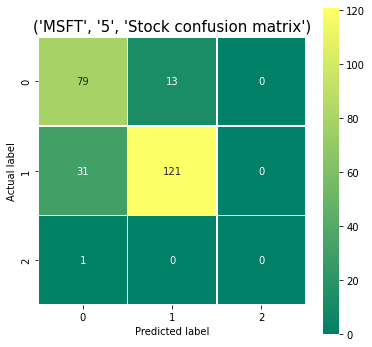

The accuracy of the model is: 81.09 %
The f1 value for the model is: 54.03 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


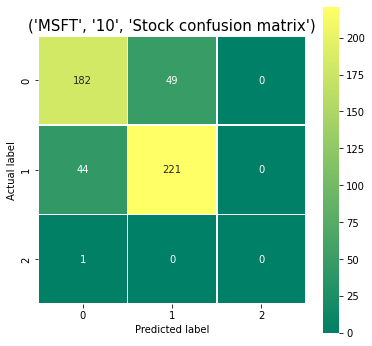

The accuracy of the model is: 81.31 %
The f1 value for the model is: 81.31 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


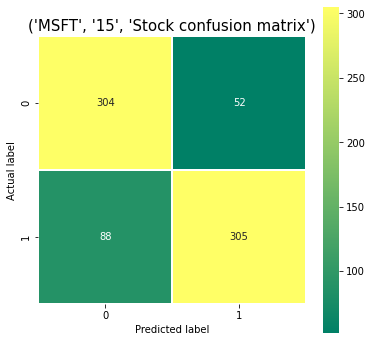

The accuracy of the model is: 81.82 %
The f1 value for the model is: 81.82 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


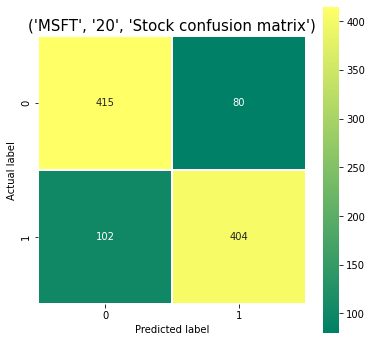

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BP
The accuracy of the model is: 72.24 %
The f1 value for the model is: 47.97 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


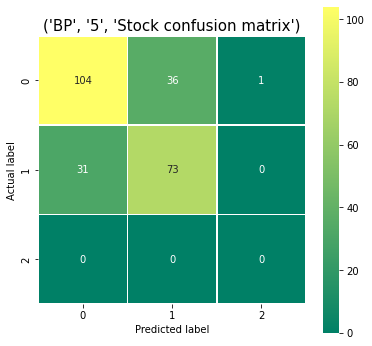

The accuracy of the model is: 71.83 %
The f1 value for the model is: 71.83 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


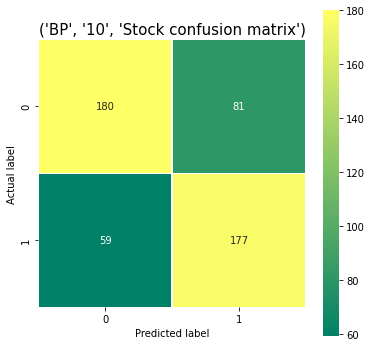

The accuracy of the model is: 70.76 %
The f1 value for the model is: 47.30 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


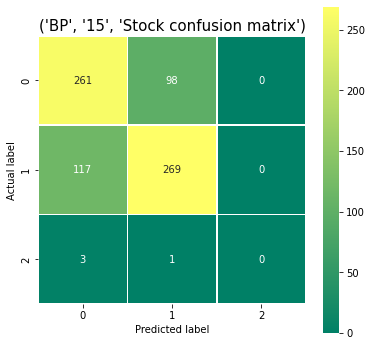

The accuracy of the model is: 75.12 %
The f1 value for the model is: 75.11 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


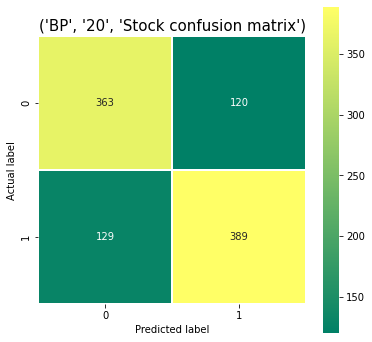

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DIS
The accuracy of the model is: 82.04 %
The f1 value for the model is: 54.79 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


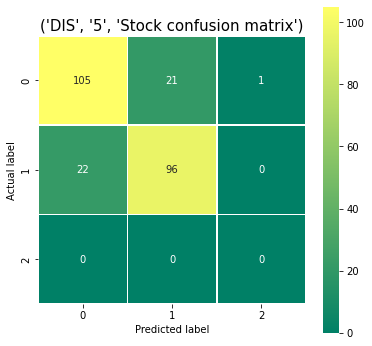

The accuracy of the model is: 81.49 %
The f1 value for the model is: 54.34 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


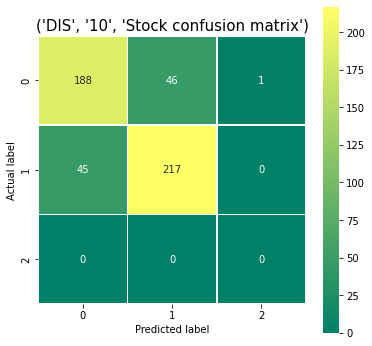

The accuracy of the model is: 81.84 %
The f1 value for the model is: 81.84 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


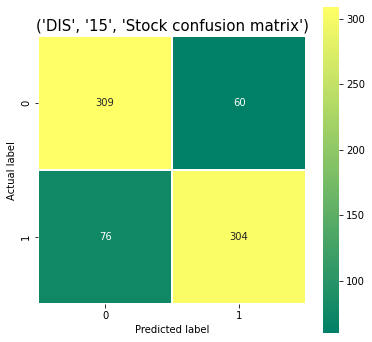

The accuracy of the model is: 83.12 %
The f1 value for the model is: 83.03 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


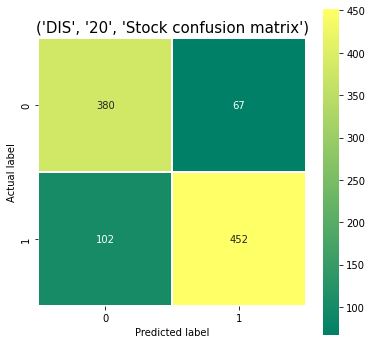

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
LMT
The accuracy of the model is: 85.31 %
The f1 value for the model is: 85.26 %


/home/chris/Project_dir/Project_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to '1.0') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


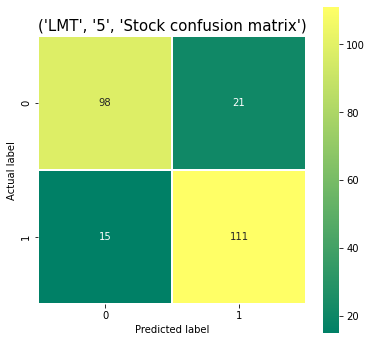

KeyboardInterrupt: 

In [ ]:
Tickers = ["MSFT","BP","DIS","LMT","BTC-USD"]
for tick in Tickers:
    stock5 = yf.download([tick],period = "5y")
    stock10 = yf.download([tick],period = "10y")
    stock15 = yf.download([tick],period = "15y")
    stock20 = yf.download([tick],period = "20y")
    print(tick)
    yearsused = 5
    years = [stock5,stock10,stock15,stock20]
    for stock in years:
        #print(stock.head())
        close_price = stock["Close"]
        volume = stock["Volume"]
        Open = stock["Open"]
        
        CHANGE = np.array([])

        MA50 = MA(close_price, 50)                                          # 50-day Moving Average
        EMA50 = EMA(close_price, MA50, 50)                                  # 50-day Exponential Moving Average
        MA200 = MA(close_price, 200)                                        # 200-day Moving Average
        EMA200 = EMA(close_price, MA200, 200)                               # 200-day Exponential Moving Average
        RSI14 = RSI(close_price, 14)                                        # RSI
        STOCH_K, STOCH_D = STOCH_RSI(close_price, 14, 14, 3)                # Stochastic RSI
        MACD_VALUE, SIG_LINE, MACD_HIST = MACD(close_price, 12, 26, 9)      # MACD
        BB_UP, BB_MID, BB_DOWN = BB(close_price, 20, 2)                     # Bollinger Bands
        #ADX14 = ADX(stock, 14)                                           # ADX

        #stock["MA 50"] = MA50
        #stock["EMA 50"] = EMA50
        #stock["MA 200"] = MA200
        #stock["EMA 200"] = EMA200
        stock["RSI 14"] = RSI14
        stock["STOCH K"] = STOCH_K
        stock["STOCH D"] = STOCH_D
        stock["MACD VALUE"] = MACD_VALUE
        stock["SIG LINE"] = SIG_LINE
        stock["MACD HIST"] = MACD_HIST
        #stock["BB UP"] = BB_UP
        #stock["BB MID"] = BB_MID
        #stock["BB DOWN"] = BB_DOWN
        #stock["ADX"] = ADX14
        PercChange = np.array([])
        for i in range(0,len(Open)-1):    
            if Open[i]<Open[i+1]:
                CHANGE = np.append(CHANGE, 1)
            else:
                CHANGE = np.append(CHANGE, 0)
                
            perc = (Open[i] - close_price[i])/100
            PercChange = np.append(PercChange,perc)
        PercChange = np.append(PercChange, 0)
        CHANGE = np.append(CHANGE, "NaN")
        stock["Change"] = CHANGE
        stock["PercentChange"] = PercChange
        stock.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
        
    
        features = ["Open","Close","RSI 14","STOCH K","STOCH D", "MACD VALUE", "SIG LINE", "MACD HIST",
           "PercentChange"]


        ratio = round(0.8*stock.shape[0])
        X = stock[features]
        Y = stock["Change"]

        X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=ratio)
        #print(X_train.shape, y_train.shape)
        model=SVC(kernel="linear",C=100,random_state = 42069)
        svmfit = model.fit(X_train,y_train)

        y_preds = svmfit.predict(X_test)
        print('The accuracy of the model is: {:.2f}'.format(accuracy_score(y_test, y_preds)*100),"%")
    #     print('The recall score for the dataset using SVM is',(recall_score(y_test,y_preds,pos_label="1.0")*100),'%')
    #     print('The precision percent value for the dataset using SVM is',(precision_score(y_test,y_preds,pos_label="1.0")*100),'%')
        print('The f1 value for the model is: {:.2f}'.format(f1_score(y_test,y_preds,average = "macro",pos_label="1.0")*100),'%')
        
        cm_svm = metrics.confusion_matrix(y_preds,y_test)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm_svm,annot=True,fmt="d",linewidths=.5,square=True,cmap="summer")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        all_sample_title=(tick,str(yearsused),"Stock confusion matrix")
        plt.title(all_sample_title,size=15)
        plt.show()
        yearsused = yearsused + 5

Note to whoever reads this, I was re running the code to check something minor that has no effect on the project. But ran out of time on a work day to rerun it fully. :)